In [27]:
import json
import numpy as np
import pandas as pd

from pipeline.utils.file_helpers import get_annotations, get_timestamps
from pipeline.post_processing.post_process_timestamps import extend_timestamps, interpolate_time_remaining

annotations_fp = "/playpen-storage/levlevi/nba-positions-videos-dataset/testing/quantitative-benchmark/assets/annotations/annotations.json"
timestamps_fp = "/playpen-storage/levlevi/nba-positions-videos-dataset/testing/quantitative-benchmark/assets/annotations/timestamps.json"

annotations = get_annotations(annotations_fp)
timestamps = get_timestamps(timestamps_fp) 

for k in timestamps:
    extend_timestamps(timestamps[k])

In [28]:
analysis_dict = {}

for k in annotations:
    analysis_dict[k] = {}
    time_remaining_vals = []
    for idx in annotations[k]:
        time_remaining = annotations[k][idx]['time_on_clock']
        time_remaining_vals.append(time_remaining)
    analysis_dict[k]['gt_time_remaining'] = time_remaining_vals

for k in timestamps:
    time_remaining_vals = []
    for idx in timestamps[k]:
        time_remaining = timestamps[k][idx]['time_remaining']
        time_remaining_vals.append(time_remaining)
    analysis_dict[k]['pred_time_remaining'] = time_remaining_vals

In [29]:
for k in analysis_dict:
    analysis_dict[k]['pred_time_remaining'] = interpolate_time_remaining(analysis_dict[k]['pred_time_remaining'])

In [30]:
for k in analysis_dict:
    tr_errs = []
    pred_tr = analysis_dict[k]['pred_time_remaining']
    gt_tr = analysis_dict[k]['gt_time_remaining']
    for tr1, tr2 in zip(pred_tr, gt_tr):
        tr_errs.append(np.abs(tr1 - tr2)) if tr1 and tr2 else tr_errs.append(np.nan)
    analysis_dict[k]['tr_errs'] = tr_errs

In [31]:
for k in analysis_dict:
    det = 0
    total = 0
    for tr1, tr2 in zip(analysis_dict[k]['gt_time_remaining'], analysis_dict[k]['pred_time_remaining']):
        if tr1:
            total += 1
        if tr2 and tr1:
            det += 1
    if total == 0:
        analysis_dict[k]['recall'] = np.nan
    else:
        analysis_dict[k]['recall'] = det / total

In [32]:
analysis_df = pd.DataFrame()

video_file_paths = []
mean_tr_errs = []
recall = []
for k in analysis_dict:
    video_file_paths.append(k)
    mean_tr_err = np.nanmean(analysis_dict[k]['tr_errs'])
    mean_tr_errs.append(mean_tr_err)
    recall.append(analysis_dict[k]['recall'])

analysis_df['video_file_paths'] = video_file_paths
analysis_df['mean_tr_abs_errs'] = mean_tr_errs
analysis_df['recall'] = recall
analysis_df.sort_values(by='mean_tr_abs_errs', ascending=False).head()

/tmp/ipykernel_3292399/973810201.py:8: RuntimeWarning: Mean of empty slice
  mean_tr_err = np.nanmean(analysis_dict[k]['tr_errs'])


,video_file_paths,mean_tr_abs_errs,recall
1,/playpen-storage/levlevi/nba-positions-videos-...,5.773402,1.0
17,/playpen-storage/levlevi/nba-positions-videos-...,5.623649,1.0
13,/playpen-storage/levlevi/nba-positions-videos-...,5.552365,1.0
37,/playpen-storage/levlevi/nba-positions-videos-...,5.552365,1.0
15,/playpen-storage/levlevi/nba-positions-videos-...,5.533670,1.0


In [33]:
avg_mean_tr_err = np.mean(analysis_df['mean_tr_abs_errs'])
mean_recall = np.mean(analysis_df['recall'])
print(avg_mean_tr_err, mean_recall)

3.060173486377026 0.8936170212765957


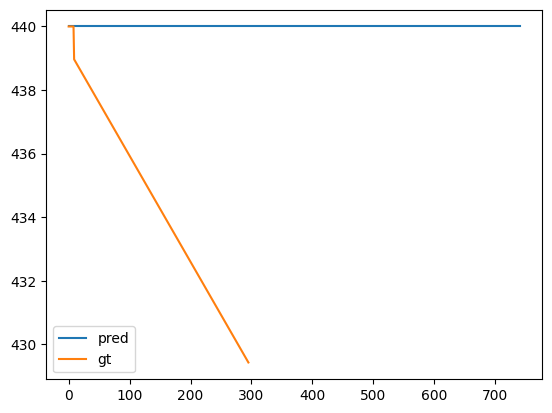

In [34]:
import matplotlib.pyplot as plt

ex_key = video_file_paths[17]
ex_tr_pred_vals = sorted(analysis_dict[ex_key]['pred_time_remaining'])[::-1]
ex_tr_gt_vals = analysis_dict[ex_key]['gt_time_remaining']

plt.plot(ex_tr_pred_vals, label='pred')
plt.plot(ex_tr_gt_vals, label='gt')
plt.legend()
plt.show()
plt.close()